In [1]:
# Basic libraries
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm        # Progress bar library for Jupyter Notebook

# Deep learning framework for building and training models
import tensorflow as tf
## Pre-trained model for image feature extraction
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Tokenizer class for captions tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

## Function for padding sequences to a specific length
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Class for defining Keras models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda

# For checking score
from nltk.translate.bleu_score import corpus_bleu

In [4]:
pip install nltk

  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     ------------------ ------------------- 20.5/42.0 kB 330.3 kB/s eta 0:00:01
     -------------------------------------  41.0/42.0 kB 393.8 kB/s eta 0:00:01
     -------------------------------------- 42.0/42.0 kB 341.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.5 MB 1.6 MB/s eta 0:00:01
   ------- -------------------------------- 0.3/1.5 MB 3.7 MB/s eta 0:00:01
   ------------- -------------------------- 0.5/1.5 MB 4.0 MB/s eta 0:00:01
   -------------------- ------------------- 0.8/1.5 MB 4.8 MB/s eta 0:00:01
   ----------------------------- ---------- 1.1/1.5 MB 5.8 MB/s eta 0:00:01
   -------------------------------------- - 1.4/1.5 MB 6.1 MB/s eta 0:00:01
   --------------------------

In [2]:
BASE_DIR = 'C:\\Users\\priya\\Downloads\\IMGCAP'
WORKING_DIR = 'C:\\Users\\priya\\Downloads\\kaggle'

In [3]:
# We are going to use pretraind vgg model
# Load the vgg16 model
model = VGG16()

# Restructuring the model to remove the last classification layer, this will give us access to the output features of the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Printing the model summary
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [5]:
from keras.applications import VGG16
from keras.models import Model

# Load the VGG16 model
model = VGG16()

# Restructuring the model to remove the last classification layer
# This will give us access to the output features of the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)


In [6]:
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:


# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:
import os
from tqdm import tqdm
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input 

In [8]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [6]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [7]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [8]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

100%|██████████| 40456/40456 [00:00<00:00, 1192209.28it/s]


In [10]:
len(mapping)

8091

In [11]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [12]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
# preprocess the text
clean(mapping)

In [14]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
len(all_captions)

40455

In [19]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [20]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [21]:
import os
from tqdm import tqdm
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer

In [22]:
vocab_size

8485

In [23]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [24]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [25]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [29]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [27]:
import os
from tqdm import tqdm
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Input , Dropout , Dense , Embedding , LSTM , add 

In [28]:
import os
from tqdm import tqdm
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.utils import plot_model

In [31]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

TypeError: `output_signature` must contain objects that are subclass of `tf.TypeSpec` but found <class 'list'> which is not.

In [30]:
epochs = 50
batch_size = 32

# Calculate the steps_per_epoch based on the number of batches in one epoch
steps_per_epoch = len(train) // batch_size
  # Calculate the steps for validation data

# Loop through the epochs for training
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Set up data generators
    train_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    test_generator = data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch,verbose=1)

Epoch 1/50


TypeError: `output_signature` must contain objects that are subclass of `tf.TypeSpec` but found <class 'list'> which is not.

In [50]:
import numpy as np
import tensorflow as tf

def data_generator(data, labels, batch_size):
    num_samples = len(data)
    while True:
        indices = np.random.choice(num_samples, batch_size, replace=False)
        batch_data = data[indices]
        batch_labels = labels[indices]
        yield batch_data, batch_labels

# Example usage:
train_generator = data_generator( max_length, vocab_size, batch_size)
test_generator = data_generator( max_length, vocab_size, batch_size)
batch_size = 32


# Now you can use train_generator in model.fit() or model.evaluate()


Epoch 50/50

In [32]:
import numpy as np
import os
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

In [34]:
import os
from tqdm import tqdm
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [51]:
def data_generator(train_data, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        # Generate batches of data
        for i in range(0, len(train_data), batch_size):
            batch_data = train_data[i:i+batch_size]
            
            # Process batch_data to generate inputs and outputs
            
            # Example:
            batch_inputs = []  # List to store batch inputs
            batch_outputs = []  # List to store batch outputs
            
            for data_item in batch_data:
                # Process data_item to generate input and output
                
                # Example:
                input_sequence = ...  # Generate input sequence
                output_sequence = ...  # Generate output sequence
                
                batch_inputs.append(input_sequence)
                batch_outputs.append(output_sequence)
            
            # Yield inputs and outputs as a tuple
            yield (np.array(batch_inputs), np.array(batch_outputs))


In [52]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [53]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [54]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Predicted---------------------')
    for caption in captions[:2]:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    
    plt.imshow(image)

---------------------Predicted---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq


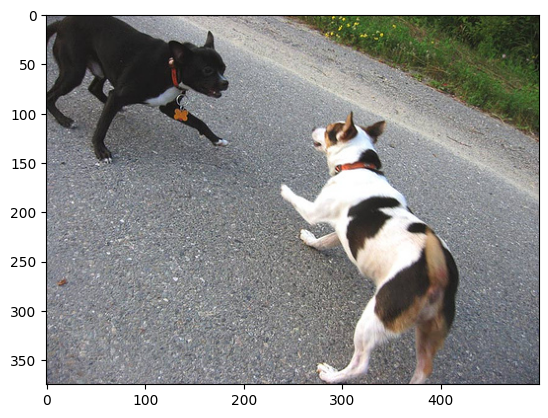

In [55]:
generate_caption("1001773457_577c3a7d70.jpg")

In [57]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Predicted---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    
    plt.imshow(image)

---------------------Predicted---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq


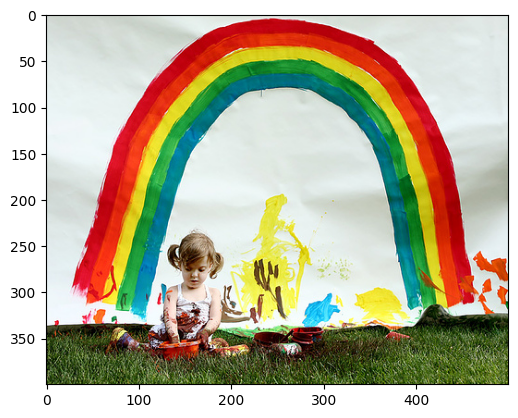

In [65]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Predicted---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq


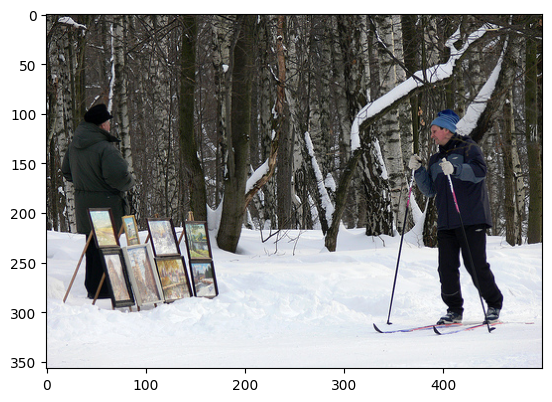

In [66]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Predicted---------------------
startseq black boy and white boy in swimming trunks are hugging each other on beach or lake endseq
startseq white boy and black boy embrace endseq
startseq two boys in red swim trunks hold each other in the water endseq
startseq two kids are hugging playfully in shallow water endseq
startseq two kids are standing in the ocean hugging each other endseq


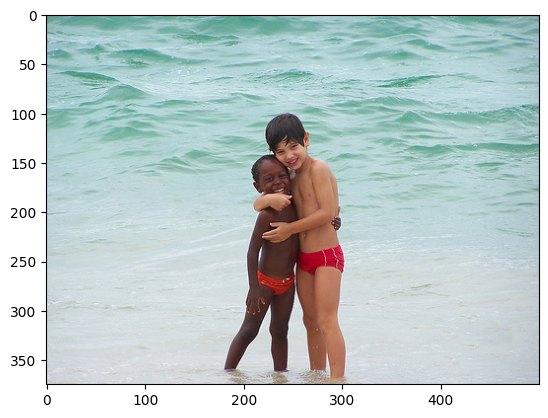

In [59]:
generate_caption("812196663_0c969970b5.jpg")

In [96]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


TypeError: `output_signature` must contain objects that are subclass of `tf.TypeSpec` but found <class 'list'> which is not.

In [95]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(data, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        for i in range(0, len(data), batch_size):
            batch_data = data[i:i+batch_size]
            batch_features = []
            batch_captions = []
            for key in batch_data:
                feature = features[key][0]
                caption_list = mapping[key]
                for caption in caption_list:
                    sequence = tokenizer.texts_to_sequences([caption])[0]
                    for i in range(1, len(sequence)):
                        in_seq, out_seq = sequence[:i], sequence[i]
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                        batch_features.append(feature)
                        batch_captions.append(out_seq)
            yield ([np.array(batch_features), np.array(batch_captions)], np.array(batch_captions))



In [97]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(data, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        for i in range(0, len(data), batch_size):
            batch_data = data[i:i+batch_size]
            batch_features = []
            batch_captions = []
            for key in batch_data:
                feature = features[key][0]
                caption_list = mapping[key]
                for caption in caption_list:
                    sequence = tokenizer.texts_to_sequences([caption])[0]
                    for i in range(1, len(sequence)):
                        in_seq, out_seq = sequence[:i], sequence[i]
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                        batch_features.append(feature)
                        batch_captions.append(out_seq)
            yield ([np.array(batch_features), np.array(batch_captions)], np.array(batch_captions))

# Assuming train, mapping, features, tokenizer, max_length, vocab_size, and batch_size are defined
train_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# Calculate steps per epoch
steps_per_epoch = len(train) // batch_size

# Train the model
model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch, verbose=1)


TypeError: `output_signature` must contain objects that are subclass of `tf.TypeSpec` but found <class 'list'> which is not.

In [98]:
import tensorflow as tf

# Define the output signature
output_signature = (
    (
        tf.TensorSpec(shape=(None, num_features), dtype=tf.float32),  # Example for features
        tf.TensorSpec(shape=(None, max_length, vocab_size), dtype=tf.float32),  # Example for captions
    ),
    tf.TensorSpec(shape=(None, max_length, vocab_size), dtype=tf.float32)  # Example for captions
)

# Assuming num_features, max_length, and vocab_size are defined appropriately

# Now you can use this output signature when calling the from_generator function
dataset = tf.data.Dataset.from_generator(
    generator, 
    output_signature=output_signature
)


NameError: name 'num_features' is not defined

In [104]:
import tensorflow as tf

# Define the values for num_features, max_length, and vocab_size
num_features = 8091# Replace ... with the actual number of features
max_length = 35  # Replace ... with the maximum length of captions
vocab_size = 8485  # Replace ... with the size of the vocabulary

# Define the output signature
output_signature = (
    (
        tf.TensorSpec(shape=(None, num_features), dtype=tf.float32),  # Example for features
        tf.TensorSpec(shape=(None, max_length, vocab_size), dtype=tf.float32),  # Example for captions
    ),
    tf.TensorSpec(shape=(None, max_length, vocab_size), dtype=tf.float32)  # Example for captions
)

# Now you can use this output signature when calling the from_generator function
dataset = tf.data.Dataset.from_generator(
    generator, 
    output_signature=output_signature
)


TypeError: `generator` must be a Python callable.

In [106]:
def generator_function():
    # Generate data samples here
    while True:
        # Generate a data sample
        data_sample = ...  # Generate or yield data sample
        yield data_sample

# Call the generator function and create a generator object
generator = generator_function()

# Now you can use the generator object when calling the from_generator function
dataset = tf.data.Dataset.from_generator(
    generator, 
    output_signature=output_signature
)



TypeError: `generator` must be a Python callable.

In [107]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [113]:
image_path = 'C:\\Users\\priya\\Downloads\\IMGCAP\\Images\\979383193_0a542a059d.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)


'startseq noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle noodle'

---------------------Predicted---------------------
startseq two children laying on the floor with group of wooden blocks above their heads endseq
startseq two children re laying on rug with some wooden bricks laid out in square between them endseq
startseq two kids lie on rug near wooden blocks and smile endseq
startseq two little girls lie on the carpet next to an made of wooden blocks endseq
startseq two young girls lay on the carpet next to wooden blocks endseq


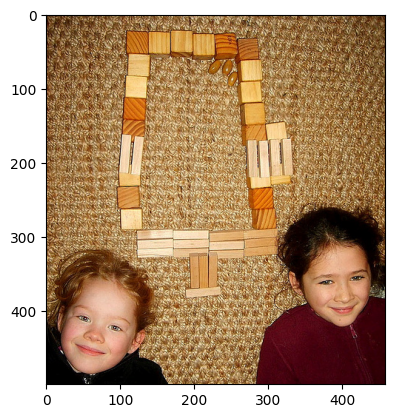

In [62]:
generate_caption("847782643_57248bbdab.jpg")


---------------------Predicted---------------------
startseq girls with orange hair standing on the street with some kind of bottle in their hand endseq
startseq two girls walking in the street endseq
startseq two girls walking next to each other and talking endseq
startseq two teenage girls dressed like hippies walk and talk endseq
startseq "two women one with head bandanna are standing next to each other while one holds bottle ." endseq


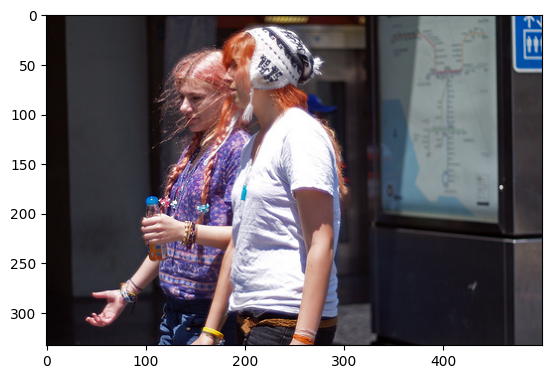

In [63]:
generate_caption("862156271_3eacea90a8.jpg")

---------------------Predicted---------------------
startseq two girls are riding wheeler endseq
startseq two girls are sitting on an atv on the sand in front of bridge endseq
startseq two girls riding an atv endseq
startseq two kids are posing on black atv that is on top of sand endseq
startseq two young girls drive an atv endseq


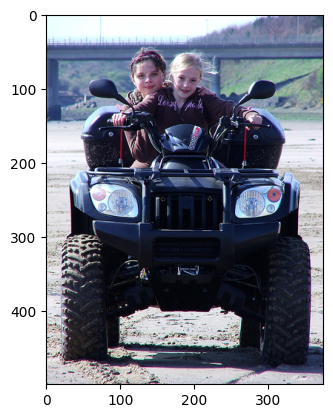

In [64]:
generate_caption("492341908_1ef53be265.jpg")

---------------------Predicted---------------------
startseq two girls are riding wheeler endseq
startseq two girls are sitting on an atv on the sand in front of bridge endseq
startseq two girls riding an atv endseq
startseq two kids are posing on black atv that is on top of sand endseq
startseq two young girls drive an atv endseq


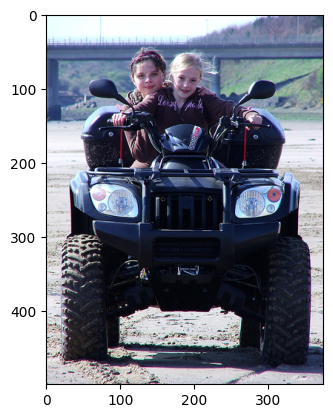

In [40]:
generate_caption("492341908_1ef53be265.jpg")

---------------------Predicted---------------------
startseq two girls are riding wheeler endseq
startseq two girls are sitting on an atv on the sand in front of bridge endseq
startseq two girls riding an atv endseq
startseq two kids are posing on black atv that is on top of sand endseq
startseq two young girls drive an atv endseq


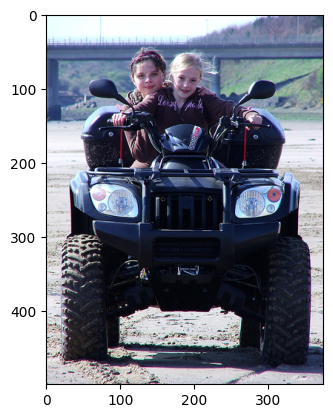

In [41]:
generate_caption("492341908_1ef53be265.jpg")

---------------------Predicted---------------------
startseq two children laying on the floor with group of wooden blocks above their heads endseq
startseq two children re laying on rug with some wooden bricks laid out in square between them endseq
startseq two kids lie on rug near wooden blocks and smile endseq
startseq two little girls lie on the carpet next to an made of wooden blocks endseq
startseq two young girls lay on the carpet next to wooden blocks endseq


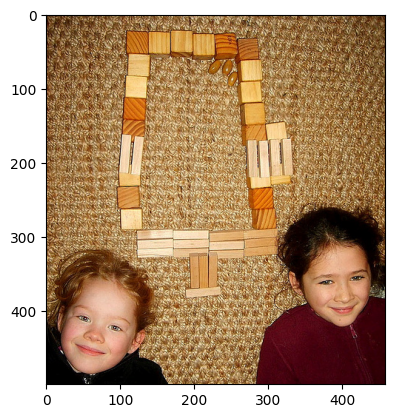

In [42]:
generate_caption("847782643_57248bbdab.jpg")

---------------------Predicted---------------------
startseq two children laying on the floor with group of wooden blocks above their heads endseq
startseq two children re laying on rug with some wooden bricks laid out in square between them endseq
startseq two kids lie on rug near wooden blocks and smile endseq
startseq two little girls lie on the carpet next to an made of wooden blocks endseq
startseq two young girls lay on the carpet next to wooden blocks endseq


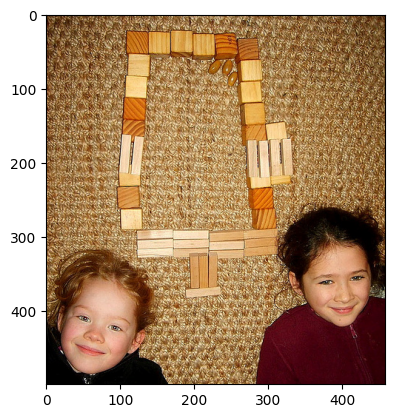

In [43]:
generate_caption("847782643_57248bbdab.jpg")

---------------------Predicted---------------------
startseq bug sits on girls finger while she looks shocked endseq
startseq girl in school uniform screams with bug on her finger endseq
startseq girl looks at bug on her finger and looks scared endseq
startseq young girl makes face as she looks at an insect on her finger endseq
startseq the girl with glasses on has bug on her right pointer finger endseq


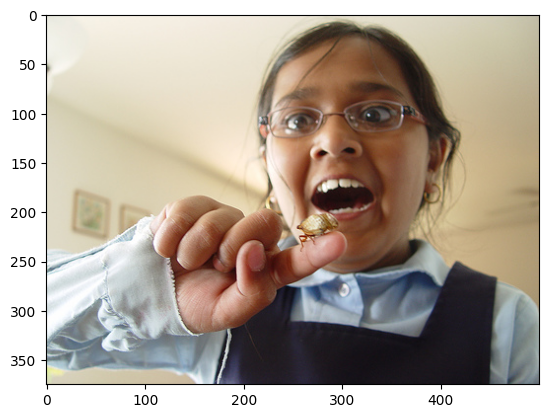

In [45]:
generate_caption("516648762_0cff84ea97.jpg")

---------------------Predicted---------------------
startseq boy peeks his head through painted picture endseq
startseq child poses within mock pumpkin head endseq
startseq child stand behind cutout picture endseq
startseq little boy with face inside painted pumpkin endseq
startseq the child has his head in the frame of the painting endseq


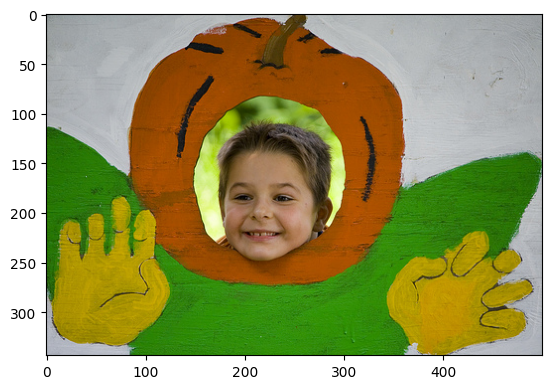

In [46]:
generate_caption("3756150099_50882fc029.jpg")

---------------------Predicted---------------------
startseq boy peeks his head through painted picture endseq
startseq child poses within mock pumpkin head endseq
startseq child stand behind cutout picture endseq
startseq little boy with face inside painted pumpkin endseq
startseq the child has his head in the frame of the painting endseq


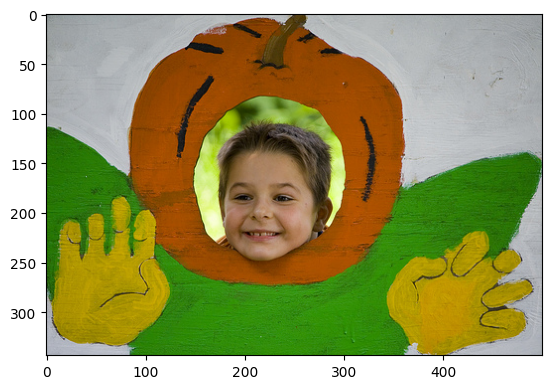

In [47]:
generate_caption("3756150099_50882fc029.jpg")

---------------------Predicted---------------------
startseq boy peeks his head through painted picture endseq
startseq child poses within mock pumpkin head endseq
startseq child stand behind cutout picture endseq
startseq little boy with face inside painted pumpkin endseq
startseq the child has his head in the frame of the painting endseq


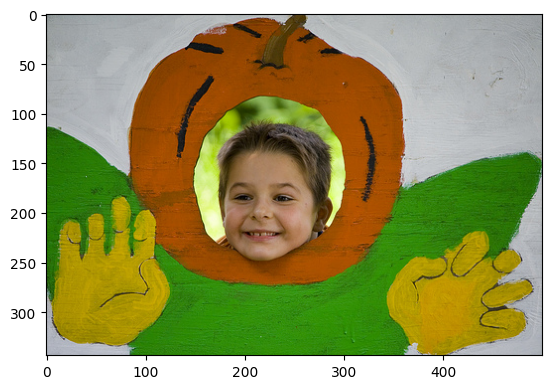

In [48]:
generate_caption("3756150099_50882fc029.jpg")

---------------------Predicted---------------------
startseq boy peeks his head through painted picture endseq
startseq child poses within mock pumpkin head endseq
startseq child stand behind cutout picture endseq
startseq little boy with face inside painted pumpkin endseq
startseq the child has his head in the frame of the painting endseq


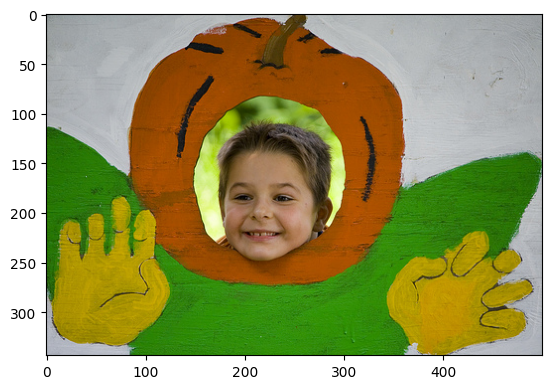

In [49]:
generate_caption("3756150099_50882fc029.jpg")

---------------------Predicted---------------------
startseq woman wearing brightly colored costume stands onstage endseq
startseq "brightly dressed feather headed wearing women competing on stage in some sort of pagent ." endseq
startseq costumed women perform outdoors endseq
startseq several women dressed in colorful costumes near city hall building endseq
startseq women in costume stand on stage endseq


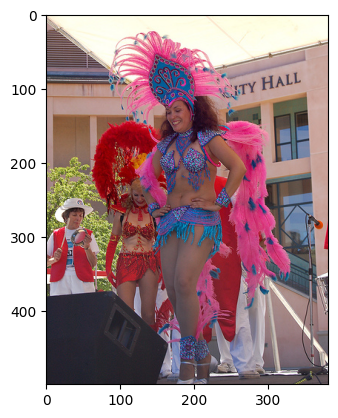

In [50]:
generate_caption("875731481_a5a0a09934.jpg")

---------------------Predicted---------------------
startseq boy is swimming underwater holding toy in his hand endseq
startseq little boy swimming underwater with toy in his hand endseq
startseq little boy swims underwater endseq
startseq "a little boy underwater in pool holding plastic dinosaur ." endseq
startseq child swimming underwater with toy in his hand endseq


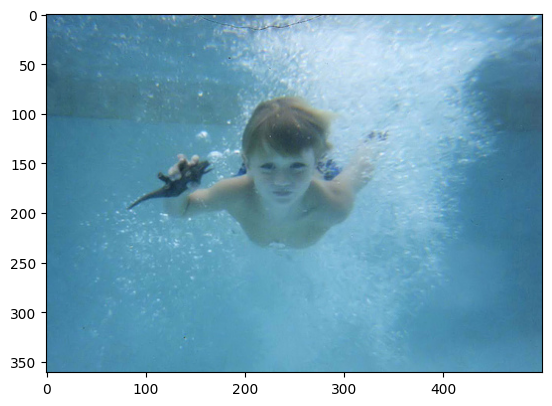

In [51]:
generate_caption("897621891_efb1e00d1d.jpg")

---------------------Predicted---------------------
startseq boy is swimming underwater holding toy in his hand endseq
startseq little boy swimming underwater with toy in his hand endseq
startseq little boy swims underwater endseq
startseq "a little boy underwater in pool holding plastic dinosaur ." endseq
startseq child swimming underwater with toy in his hand endseq


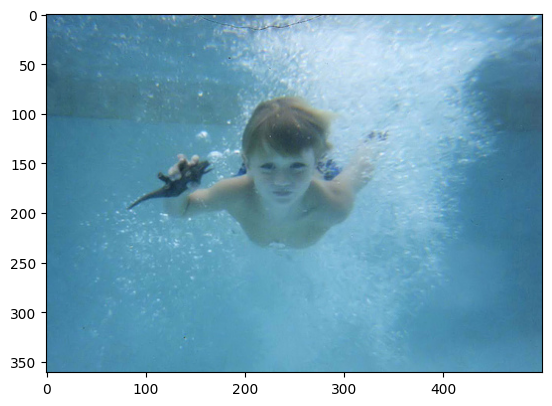

In [53]:
generate_caption("897621891_efb1e00d1d.jpg")

---------------------Predicted---------------------
startseq boy is swimming underwater holding toy in his hand endseq
startseq little boy swimming underwater with toy in his hand endseq
startseq little boy swims underwater endseq
startseq "a little boy underwater in pool holding plastic dinosaur ." endseq
startseq child swimming underwater with toy in his hand endseq


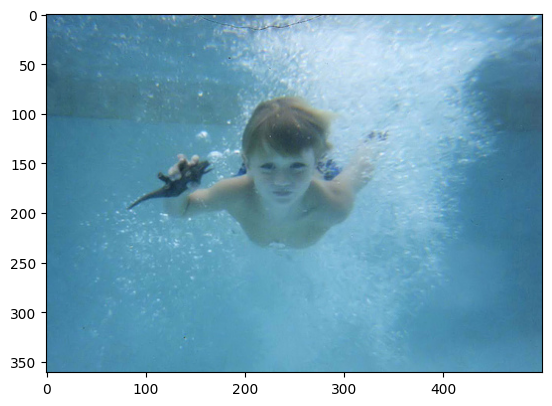

In [54]:
generate_caption("897621891_efb1e00d1d.jpg")

---------------------Predicted---------------------
startseq boy is swimming underwater holding toy in his hand endseq
startseq little boy swimming underwater with toy in his hand endseq
startseq little boy swims underwater endseq
startseq "a little boy underwater in pool holding plastic dinosaur ." endseq
startseq child swimming underwater with toy in his hand endseq


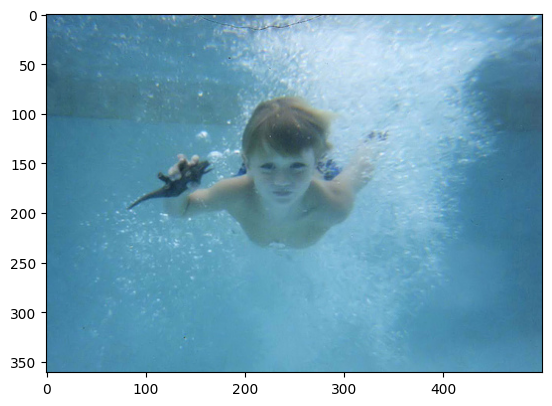

In [55]:
generate_caption("897621891_efb1e00d1d.jpg")

---------------------Predicted---------------------
startseq child is playing in the muddy water running along grassy area endseq
startseq little boy is sitting on wet path covered in mud endseq
startseq small boy sits in mud puddle and gets covered with mud endseq
startseq very dirty young blond boy playing in the mud endseq
startseq the little kid sits down in the muddy water endseq


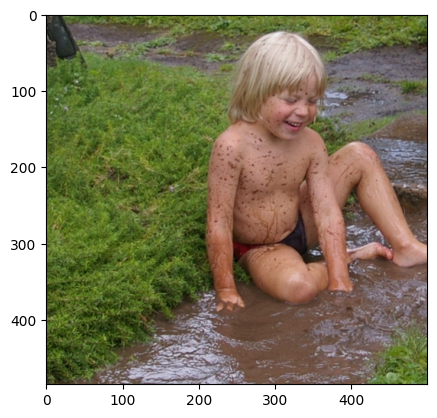

In [56]:
generate_caption("961189263_0990f3bcb5.jpg")

---------------------Predicted---------------------
startseq boy licks an older male 's face that 's covered in blue and yellow creamy substance endseq
startseq child in yellow shirt is licking brightly colored food off of mans cheek endseq
startseq young boy is licking blue and yellow frosting off young man 's face endseq
startseq young boy is licking colored frosting off young man 's face endseq
startseq someone licks the face of man with blue and yellow paint on his face endseq


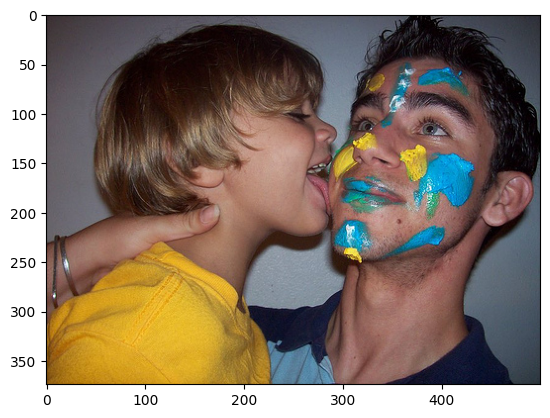

In [57]:
generate_caption("957230475_48f4285ffe.jpg")

In [1]:
generate_caption("836828001_af98d16256.jpg")

NameError: name 'generate_caption' is not defined

In [59]:
generate_caption("  717673249_ac998cfbe6.jpg")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\priya\\Downloads\\IMGCAP\\Images\\  717673249_ac998cfbe6.jpg'

---------------------Predicted---------------------
startseq calico cat raising its paws towards dog with an open mouth endseq
startseq cat swatting at doberman dog endseq
startseq dog and cat are fighting on chair endseq
startseq multicolor cat fighting with black and brown dog in red collar endseq
startseq the yellow and black cat and the brown and black dog are fighting endseq


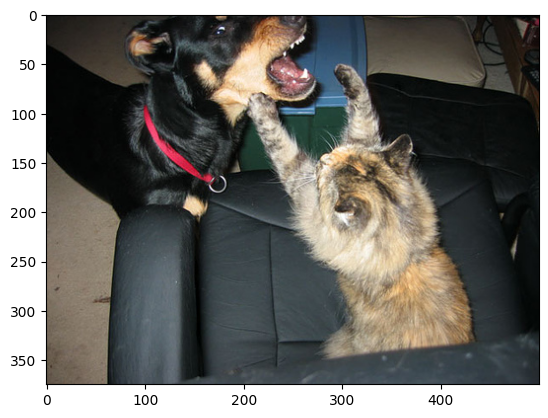

: 

In [60]:
generate_caption("97406261_5eea044056.jpg")